In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import sys
import cv2
from skimage.io import imread, imread_collection
from scipy import signal
import scipy.misc
#from scipy.misc import imread
from scipy.ndimage import filters,distance_transform_edt
from matplotlib import pyplot as plt

import os
from os import listdir
from PIL import Image

from keras.models import Model
from keras import optimizers
from keras.layers import Input,Activation,Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization,Dropout

In [ ]:
path_train_input ='/content/drive/MyDrive/Binary/dist_img'
#path_test_input='/content/drive/MyDrive/dist_test/images'
path_train_gt = '/content/drive/MyDrive/Binary/dist_gt'
#path_test_gt='/content/drive/MyDrive/dist_test/labels'


path_predict='/content/drive/MyDrive/predict_bhi'
path_output='/content/drive/MyDrive'
#path_frcnn_predict=dir_path+'/frcnn_predict'

nb_epoch =100
batch_size = 10
weight_file='/content/drive/MyDrive/18_05_Aug_Dist_HeLa_reg_ep100.hdf5'

In [ ]:
#As this is a regression problem, train_label should be also normalized.
def prep_data(path_img,path_gt):
    data = []
    label = []

    img_list = sorted(listdir(path_img))
    gt_list=sorted(listdir(path_gt))
    i=0
    while (i<len(img_list)):
        img = np.array(cv2.imread(path_img +'/'+ img_list[i],0),dtype=np.float64)
        #img = np.array(imread(path_img +'/'+ img_list[i]))
        #print img.shape
        img=(img-np.amin(img))*1.0/(np.amax(img)-np.amin(img))#img*1.0 transform array to double
        img=img*1.0/np.median(img)
        img_h=img.shape[0]
        img_w=img.shape[1]
        img=np.resize(img,(512,512,1))
        data.append(img)

        gt =np.array(imread(path_gt + '/'+ gt_list[i]), dtype=np.float64)
#---------------with or without normalization-----------------------
        if np.count_nonzero(gt)!=0:
            nonzero_gt=gt[gt>0]
            gt=gt*1.0/np.median(nonzero_gt)

        gt=np.resize(gt,(512,512,1))
        label.append(gt)

        i+=1
    data=np.array(data)
    label=np.array(label)
    print (data.shape, label.shape)
    return data, label

In [ ]:
from sklearn.model_selection import train_test_split

# Call prep_data function to get image and mask datasets
image_dataset, mask_dataset = prep_data(path_train_input,path_train_gt)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.2, random_state=0)


(29, 512, 512, 1) (29, 512, 512, 1)


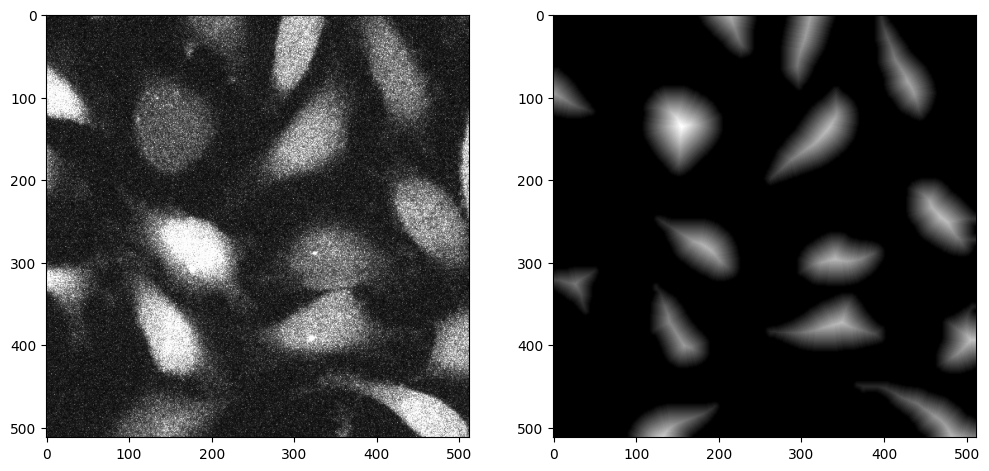

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (512, 512)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (512, 512)), cmap='gray')
plt.show()

In [ ]:
def conv_block(input_tensor, kernel, filters):
    x=Conv2D(filters, (kernel, kernel), padding='same')(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    return x
kernel = 3

In [ ]:
#------------encoder layers--------------------------------
inputs = Input((None,None, 1))
conv1=conv_block(inputs,kernel,filters=64)
conv1=conv_block(conv1,kernel,filters=64)
pool1=MaxPooling2D()(conv1)

conv2=conv_block(pool1,kernel,filters=128)
conv2=conv_block(conv2,kernel,filters=128)
pool2=MaxPooling2D()(conv2)

conv3=conv_block(pool2,kernel,filters=256)
conv3=conv_block(conv3,kernel,filters=256)
conv3=conv_block(conv3,kernel,filters=256)
pool3=MaxPooling2D()(conv3)

conv4=conv_block(pool3,kernel,filters=512)
conv4=conv_block(conv4,kernel,filters=512)
conv4=conv_block(conv4,kernel,filters=512)
pool4=MaxPooling2D()(conv4)

conv5=conv_block(pool4,kernel,filters=512)
conv5=conv_block(conv5,kernel,filters=512)
conv5=conv_block(conv5,kernel,filters=512)
pool5=MaxPooling2D()(conv5)


#--------------------decoder layers--------------------------

up6=UpSampling2D()(pool5)
conv6=conv_block(up6,kernel,filters=512)
conv6=conv_block(conv6,kernel,filters=512)
conv6=conv_block(conv6,kernel,filters=512)

up7=UpSampling2D()(conv6)
conv7=conv_block(up7,kernel,filters=512)
conv7=conv_block(conv7,kernel,filters=512)
conv7=conv_block(conv7,kernel,filters=512)

up8=UpSampling2D()(conv7)
conv8=conv_block(up8,kernel,filters=256)
conv8=conv_block(conv8,kernel,filters=256)
conv8=conv_block(conv8,kernel,filters=256)

up9=UpSampling2D()(conv8)
conv9=conv_block(up9,kernel,filters=128)
conv9=conv_block(conv9,kernel,filters=128)

up10=UpSampling2D()(conv9)
conv10=conv_block(up10,kernel,filters=64)

conv11=conv_block(conv10,kernel=1,filters=1)
outputs=Activation('relu')(conv11)

autoencoder=Model(inputs=[inputs], outputs=[outputs])

autoencoder.summary()

autoencoder.compile(loss="mean_squared_error", optimizer='adam', metrics=['mae','acc'])
print ('Compiled: OK')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    640       
                                                                 
 batch_normalization (BatchN  (None, None, None, 64)   256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, None, 64)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 batch_normalization_1 (Batc  (None, None, None, 64)   256       
 hNormalization)                                             

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping

#early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

history = autoencoder.fit(X_train, y_train,
                    batch_size = 6,
                    verbose=1,
                    epochs=150,
                    validation_data=(X_test, y_test),
                    shuffle=False)
                    #callbacks=[early_stop])



Epoch 1/150
4/4 [==============================] - 81s 8s/step - loss: 0.8086 - mae: 0.5880 - acc: 0.4164 - val_loss: 0.8417 - val_mae: 0.4962 - val_acc: 0.5659
Epoch 2/150
4/4 [==============================] - 5s 1s/step - loss: 0.5894 - mae: 0.5091 - acc: 0.5202 - val_loss: 0.8417 - val_mae: 0.4956 - val_acc: 0.5659
Epoch 3/150
4/4 [==============================] - 5s 1s/step - loss: 0.4765 - mae: 0.4459 - acc: 0.5002 - val_loss: 0.8417 - val_mae: 0.4956 - val_acc: 0.5659
Epoch 4/150
4/4 [==============================] - 5s 1s/step - loss: 0.4125 - mae: 0.3959 - acc: 0.5146 - val_loss: 0.8417 - val_mae: 0.4956 - val_acc: 0.5659
Epoch 5/150
4/4 [==============================] - 6s 1s/step - loss: 0.3910 - mae: 0.3879 - acc: 0.5085 - val_loss: 0.8417 - val_mae: 0.4956 - val_acc: 0.5658
Epoch 6/150
4/4 [==============================] - 6s 1s/step - loss: 0.3607 - mae: 0.3531 - acc: 0.5270 - val_loss: 0.8417 - val_mae: 0.4957 - val_acc: 0.5658
Epoch 7/150
4/4 [======================

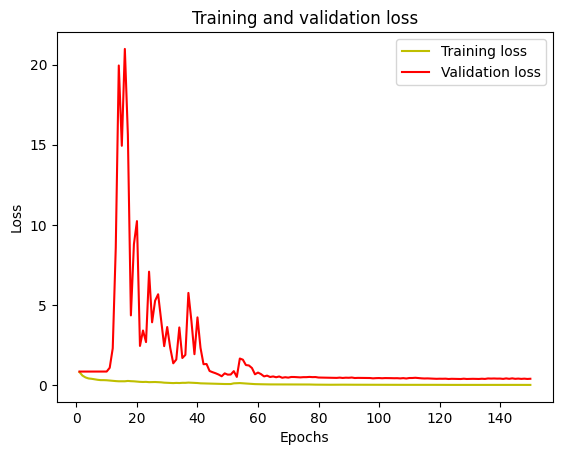

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

autoencoder.save('/content/drive/MyDrive/FCN23_05_HeLa_reg_dist_ep150.hdf5')

In [ ]:
def prep_prediction_data(path_img):
    data = []
    img_list = sorted(listdir(path_img))
    i=0
    while (i<len(img_list)):
        img = np.array(cv2.imread(path_img +'/'+ img_list[i],0),dtype=np.float64)
        img = cv2.resize(img,(512,512))
        img=(img-np.amin(img))*1.0/(np.amax(img)-np.amin(img))#img*1.0 transform array to double
        img=img*1.0/np.median(img)

        #print(np.median(img))

        img=np.reshape(img,(512,512,1))
        data.append(img)
        i+=1
    data=np.array(data)
    return data

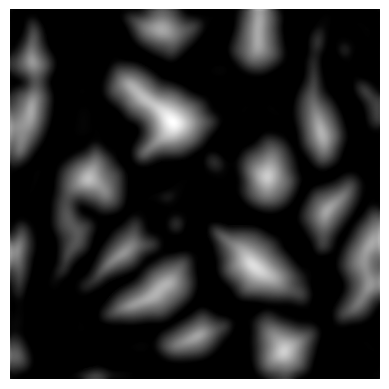

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

autoencoder.load_weights('/content/drive/MyDrive/T47D_reg_ep300.hdf5')
predict_data = prep_prediction_data(path_predict)
output = autoencoder.predict(predict_data, verbose=0)
im = output[4][:, :, 0]

# Resize the array to 512x512 using interpolation
resized_array = np.array(Image.fromarray(im).resize((512, 512), resample=Image.BILINEAR))

# Convert the resized array to an array of integers
int_array = np.array(resized_array * 255, dtype=np.uint8)

# Create an image from the integer array
img = Image.fromarray(int_array)

# Save the image as a PNG file
img.save(path_output+'/amax.png')

# Save the image as a TIFF file
img.save(path_output+'/amax.tif')

# Display the image
plt.imshow(resized_array, cmap='gray')
plt.axis('off')
plt.show()
